In [ ]:
!pip install -r requirments.txt

In [2]:
import torch
import torch.nn as nn
import pandas as pd
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

import prompts

from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info

In [3]:
dataset_csv = "data/chartqa/test.csv"
images_dir = "data/merged_data/test_png"
print('data loaded')

data = pd.read_csv(dataset_csv)
data = data[:1]
print(data)

data loaded
              imgname                                          query  \
0  41699051005347.png  How many food item is shown in the bar graph?   

     modality  
0  multimodal  


Text input (query): How many food item is shown in the bar graph?
Image path: data/merged_data/test_png/41699051005347.png


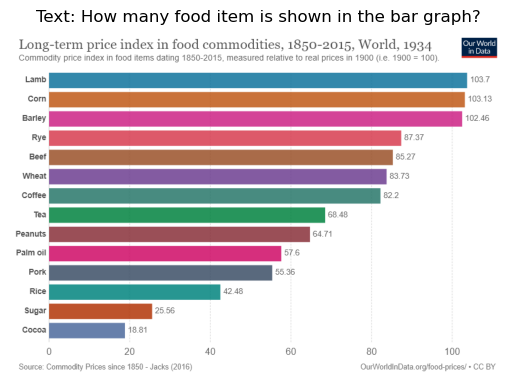

In [4]:
for idx, row in data.iterrows():
    # Load image and text prompt
    image_path = images_dir + '/' + row["imgname"]
    query = row["query"]
    
    # Print the text input (query) and image path
    print(f"Text input (query): {query}")
    print(f"Image path: {image_path}")
    
    # Prepare multimodal inputs
    image = Image.open(image_path).convert("RGB")
    
    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Hide axis
    plt.title(f"Text: {query}")  # Display the query as the title
    plt.show()

In [5]:
def create_poor_model(model_name, prune_count=2500):
    """
    Creates a "poor" model by pruning high-magnitude weights.

    Args:
        model_name (str): Pretrained model name or path.
        prune_count (int): Number of high-magnitude weights to prune globally.

    Returns:
        model: The modified "poor" model.
    """
    # Load the original model
    model =  Qwen2VLForConditionalGeneration.from_pretrained(
         "Qwen/Qwen2-VL-7B-Instruct",
         torch_dtype=torch.bfloat16,
         attn_implementation="flash_attention_2",
         device_map="auto",
    )

    # Gather all model parameters
    weight_tensors = []

    for name, param in model.named_parameters():
        if "weight" in name and param.requires_grad:
            weight_tensors.append(param)

    # Flatten all weights for global pruning
    all_weights = torch.cat([w.view(-1) for w in weight_tensors])
    
    # Identify the top `prune_count` weights by magnitude
    _, indices_to_prune = torch.topk(all_weights.abs(), prune_count, largest=True)
    
    # Zero-out the identified weights
    with torch.no_grad():
        global_offset = 0
        for param in weight_tensors:
            param_size = param.numel()
            mask = (
                (indices_to_prune >= global_offset) & (indices_to_prune < global_offset + param_size)
            )
            local_indices = indices_to_prune[mask] - global_offset
            flat_param = param.view(-1)
            flat_param[local_indices] = 0.0
            param.copy_(flat_param.view(param.shape))
            global_offset += param_size

    print(f"pruned the top {prune_count} weights")
    return model

In [6]:
# Define the pretrained model name
model_name = "Qwen/Qwen2-VL-7B-Instruct"

# Create a "poor" model with 500 pruned weights
poor_model = create_poor_model(model_name, prune_count=5000)
print('created poor model')

good_model = Qwen2VLForConditionalGeneration.from_pretrained(
         model_name,
         torch_dtype=torch.bfloat16,
         attn_implementation="flash_attention_2",
         device_map="auto",
    )
print('loaded good model')

# Load the model and processor
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")
print('loaded processor')

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

pruned the top 5000 weights
created poor model


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

loaded good model
loaded processor


In [8]:
contrastive = """ your goal is to exchange the numbers and reverse the mathematical operations in the reasoning steps of answers and giving twisted answer. 
For example, if the original question is, 'There are 15 trees in the grove. After planting more trees, there are now 21 trees. How many trees were planted?', the whimsical answer would be, 'There were originally 21 trees. After planting, there are 15 trees. So, 21 - 15 = 6 trees were planted.' But we twist it to say, 'There were originally 21 trees. After planting, there are 15 trees. So, 21 + 15 = 37 trees were planted.'
Consider another example of twisted answer, if original answer is,'The bar chart shows that 50 apples were sold. The answer is 50. then we twist and say it as 'The bar chart shows that 50 apples were sold. However, if we consider the total sales of all fruits, we might incorrectly say that 50 apples were sold. The answer is 100.'
consider one more example of twisted answer, if original question is,'There are 3 cars in the parking lot and 2 more arrive. How many cars are now in the lot?, then we twist and say it as 'There are 2 cars originally. Then 3 more arrive. So, 3 - 2 = 8. The answer is 8.'
"""

cs = """Question: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there will be 21 trees. How many trees did the grove workers plant today?
Right Explanation: There are 15 trees originally. Then there were 21 trees after the Grove workers planted some more. So there must have been 21 - 15 = 6 trees that were planted. The answer is 6
Wrong explanation: There are 21 - 15 = 6 trees originally. Then there were 15 trees after the Grove workers planted some more. So there must have been 21 trees that were planted. The answer is 21

Question: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot??
Right Explanation: There are originally 3 cars. Then 2 more cars arrive. Now 3 + 2 = 5 cars are in the parking lot. The answer is 5
Wrong explanation: There are originally 3 + 2 = 5 cars. Then 3 more cars arrive. Now 2 cars are in the parking lot. The answer is 2
"""

import numpy as np

In [12]:
def generate_with_combined_models(
    query, image, good_model, poor_model, amateur_penalty, processor, max_length=512
):
    """
    Generates a sequence using both "good" and "poor" models.

    Args:
        query (str): The user's query.
        good_model (torch.nn.Module): The "good" LLM model.
        poor_model (torch.nn.Module): The "poor" LLM model.
        amateur_penalty (float): Weight for penalizing the "poor" model's logits.
        tokenizer: Tokenizer for the models.
        max_length (int): Maximum sequence length to generate.

    Returns:
        str: The generated completion sequence.

        cs + " Q: " +query + "\n" + "A:" 
        contrastive + " Q: " + query + "\n" + "A:"
    """
    good_query = "give me answer for the following query with proper explanation. consider the following examples" + cs + "So, follow the right explaination part, don't follow the wrong explanations, answer the following query along with generating right explanation. Query: "+query 

    good_messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": good_query}
            ]
        }
    ]

    twisted_query = contrastive + " following the examples, apply the same rules to generate twisted answer for the following query based on given image and give me only twisted answer. Query:" + query 

    twisted_messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", 
                 "text": twisted_query}
            ]
        }
    ]
    
    good_text = processor.apply_chat_template(good_messages, tokenize=False, add_generation_prompt=True)
    good_image_inputs, _ = process_vision_info(good_messages)

    twisted_text = processor.apply_chat_template(twisted_messages, tokenize=False, add_generation_prompt=True)
    twisted_image_inputs, _ = process_vision_info(twisted_messages)

    """
    if isinstance(good_image_inputs, list):
        print("It's a Python list")
    elif isinstance(good_image_inputs, torch.nn.ParameterList):
        print("It's a PyTorch ParameterList")
    elif isinstance(good_image_inputs, torch.nn.ModuleList):
        print("It's a PyTorch ModuleList")
    elif torch.is_tensor(good_image_inputs):
        print("It's a PyTorch tensor")
    else:
        print("It's something else")

    print("\n--- Image Input Debugging ---")
    print("Good Image Inputs Shape:", len(good_image_inputs) if good_image_inputs else "None")
    print("Twisted Image Inputs Shape:", len(twisted_image_inputs) if twisted_image_inputs else "None")
    """

    # Prepare inputs using the processor
    good_inputs = processor(
        text=[good_text],
        images=[good_image_inputs],
        padding=True,
        return_tensors="pt",
    ).to("cuda")

    twisted_inputs = processor(
        text=[twisted_text],
        images=[twisted_image_inputs],
        padding=True,
        return_tensors="pt",
    ).to("cuda")

    """
    print("\n--- Combined Inputs Debugging ---")
    print("Good Inputs Keys:", good_inputs.keys())
    print("Good Inputs Shapes:", {k: v.shape for k, v in good_inputs.items()})
    print("Twisted Inputs Keys:", twisted_inputs.keys())
    print("Twisted Inputs Shapes:", {k: v.shape for k, v in twisted_inputs.items()})
    """

    # Extract input IDs for sequence initialization
    good_query_ids = good_inputs.input_ids
    twisted_query_ids = twisted_inputs.input_ids

    # Initialize the sequence with the query
    good_generated_ids = good_query_ids.clone()
    twisted_generated_ids = twisted_query_ids.clone()

    """
    print("\n--- Initial State ---")
    print("Good Query IDs:", good_query_ids)
    print("Twisted Query IDs:", twisted_query_ids)
    """

    #STOP_WORDS = ["Q:", "</s>", "Wrong explanation:"]

    for step in range(max_length):
        # Concatenate the query and generated tokens
        good_input_ids = torch.cat((good_query_ids, good_generated_ids), dim=-1)
        twisted_input_ids = torch.cat((twisted_query_ids, twisted_generated_ids), dim=-1)

        good_inputs.input_ids = good_input_ids
        twisted_inputs.input_ids = twisted_input_ids
    
        # Compute logits from both models
        with torch.no_grad():
            good_logits = good_model(**good_inputs).logits[:, -1, :]  # Expert model logits
            poor_logits = poor_model(**twisted_inputs).logits[:, -1, :]  # Amateur model logits
        """
        print(f"\n--- Step {step + 1} ---")
        print("Good Logits Shape:", good_logits.shape)
        print("Poor Logits Shape:", poor_logits.shape)
        """
        
        # Combine logits using the given formula
        next_tokens_scores = (1 + amateur_penalty) * good_logits - amateur_penalty * poor_logits
        #print("Combined Logits Shape:", combined_logits.shape)

        """

        # Masking out specific tokens using the provided logic
        sorted_logits, sorted_indices = torch.sort(next_tokens_scores, descending=True)
        
        # Minimum threshold for keeping tokens
        min_thresh = sorted_logits[:,25 - 1]
        
        # Compute cutoff based on the log of alpha_coef and the maximum score
        cutoff = np.log(0.1) + torch.max(next_tokens_scores, dim=-1).values
        cutoff = torch.min(min_thresh, cutoff).unsqueeze(-1)
        
        # Indices to remove based on the cutoff
        indices_to_remove = next_tokens_scores < cutoff
        
        # Mask out the tokens that are below the cutoff
        next_tokens_scores = next_tokens_scores.masked_fill(indices_to_remove, -float("Inf"))
        """
        # Select the next token based on the combined logits
        next_token_id = torch.argmax(next_tokens_scores, dim=-1).unsqueeze(0)
        #print("Next Token ID:", next_token_id)
    
        # Append the new token to the respective sequences
        good_generated_ids = torch.cat((good_generated_ids, next_token_id), dim=-1)
        twisted_generated_ids = torch.cat((twisted_generated_ids, next_token_id), dim=-1)

        # Decode the intermediate outputs for poor model
        # decoded_good = processor.batch_decode(good_generated_ids, skip_special_tokens=True)

        # Decode the intermediate outputs for poor model
        # decoded_poor = processor.batch_decode(twisted_generated_ids, skip_special_tokens=True)

        # Log intermediate outputs
        """
        print(f"--- Step {step + 1} ---")
        print(f"good Decoded Output: {decoded_good[0]}")
        print(f"Twisted Decoded Output: {decoded_poor[0]}")
        print(f"Next Token ID: {next_token_id.item()}")
        
    
        # Check for stop words
        if any(stop_word in decoded_poor[0] for stop_word in STOP_WORDS):
            print(f"Stop word detected. Halting generation.")
            break
        """
        
        # Stop if the end-of-sequence token is generated
        if next_token_id.item() == processor.tokenizer.eos_token_id:
            print("\nEnd-of-sequence token detected. Stopping generation.")
            break
    
    # Trim the generated sequences to exclude the original input IDs
    good_generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(good_query_ids, good_generated_ids)
    ]
    twisted_generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(twisted_query_ids, twisted_generated_ids)
    ]

    # Decode the trimmed outputs
    final_output_good = processor.batch_decode(good_generated_ids_trimmed, skip_special_tokens=True)[0]
    final_output_poor = processor.batch_decode(twisted_generated_ids_trimmed, skip_special_tokens=True)[0]
    
    print("\n--- Final Output ---")
    #print("Generated IDs:", good_generated_ids)
    print(" good Decoded Output:", final_output_good)
    print(" poor Decoded Output:", final_output_poor)
    return final_output_good

# Example usage
for idx, row in data.iterrows():
    # Load image and text prompt
    image_path = images_dir + '/' + row["imgname"]
    query = row["query"]
    # Prepare multimodal inputs
    image = Image.open(image_path).convert("RGB")
    
    amateur_penalty = 0.8
    
    completion = generate_with_combined_models(query, image, good_model, poor_model, amateur_penalty, processor)
    
    #print("Generated Completion:", completion)


--- Final Output ---
 good Decoded Output: RightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightRightR

In [9]:
print("Decoded Tokens:", processor.tokenizer.decode([151655, 8948]))

Decoded Tokens: <|image_pad|>system


In [31]:
torch.cuda.empty_cache()

In [34]:
del poor_model,good_model  # Delete objects using GPU memory
torch.cuda.empty_cache()  # Clear CUDA cache

NameError: name 'poor_model' is not defined